Outline:

1. Introduce the data gathering and parsing
1. How to create a VIT from the GPT code
1. Adding the text goals or adding the image observations
1. Handling the position embedding
1. Adding goal images
1. Adding the input masking
1. Switching to regresion instead of classification
1. Sanitising the data and standardization.
1. Evaluating the model in sim
1. Recording videos of the results for evaluation

## Get full trajectories
Instead of a single image we want something that looks more like a sequence, similar to text. 
For robotics applications our "language" is images and actions.

# Load Datasets

The data for robotics applications is often more complicated. There are images, actions and text descriptions. Also, the text descriptions is per episode, instead of at each frame, which is common for RL/BC.

In [5]:
# Install repo
!pip3 install -e .
!pip3 install -r requirements.txt
!pip install moviepy>=1.0.3
import cv2
# import jax
# import tensorflow as tf
import tensorflow_datasets as tfds
import tqdm
import rlds, numpy as np
import mediapy as media
from PIL import Image
from IPython import display

Obtaining file:///home/gberseth/playground/octo-mini
ERROR: file:///home/gberseth/playground/octo-mini does not appear to be a Python project: neither 'setup.py' nor 'pyproject.toml' found.


/home/gberseth/anaconda3/envs/roble/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-08-23 10:39:02.103752: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-23 10:39:02.103858: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-23 10:39:02.130754: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-23 10:39:02.195830: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlo

2024-08-23 10:55:06.537125: W external/local_tsl/tsl/platform/cloud/google_auth_provider.cc:184] All attempts to get a Google authentication bearer token failed, returning an empty token. Retrieving token from files failed with "NOT_FOUND: Could not locate the credentials file.". Retrieving token from GCE failed with "FAILED_PRECONDITION: Error executing an HTTP request: libcurl code 6 meaning 'Couldn't resolve host name', error details: Could not resolve host: metadata.google.internal".
2024-08-23 10:55:08.481292: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-08-23 10:55:08.618135: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2256] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned abov

{'steps': <_VariantDataset element_spec={'action': {'open_gripper': TensorSpec(shape=(), dtype=tf.bool, name=None), 'rotation_delta': TensorSpec(shape=(3,), dtype=tf.float32, name=None), 'terminate_episode': TensorSpec(shape=(), dtype=tf.float32, name=None), 'world_vector': TensorSpec(shape=(3,), dtype=tf.float32, name=None)}, 'is_first': TensorSpec(shape=(), dtype=tf.bool, name=None), 'is_last': TensorSpec(shape=(), dtype=tf.bool, name=None), 'is_terminal': TensorSpec(shape=(), dtype=tf.bool, name=None), 'observation': {'image': TensorSpec(shape=(480, 640, 3), dtype=tf.uint8, name=None), 'natural_language_embedding': TensorSpec(shape=(512,), dtype=tf.float32, name=None), 'natural_language_instruction': TensorSpec(shape=(), dtype=tf.string, name=None), 'state': TensorSpec(shape=(7,), dtype=tf.float32, name=None)}, 'reward': TensorSpec(shape=(), dtype=tf.float32, name=None)}>}
Instruction: Place the can to the left of the pot.


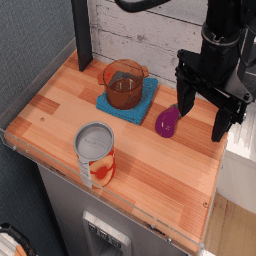

In [6]:
from PIL import Image
from IPython import display
def as_gif(images, path='temp.gif'):
  # Render the images as the gif:
  images = [Image.fromarray(image) for image in images]
  images[0].save(path, save_all=True, append_images=images[1:], duration=1000, loop=0)
  gif_bytes = open(path,'rb').read()
  return gif_bytes

# create RLDS dataset builder
builder = tfds.builder_from_directory(builder_dir='gs://gresearch/robotics/bridge/0.1.0/')
dataset = builder.as_dataset(split='train[:1]')

# sample episode + resize to 256x256 (default third-person cam resolution)
episode = next(iter(dataset))
print(episode)

steps = list(episode['steps'])
images = np.array([cv2.resize(np.array(step['observation']['image']), (256, 256)) for step in steps])

# extract goal image & language instruction
goal_image = images[-1]
language_instruction = steps[0]['observation']['natural_language_instruction'].numpy().decode()

# visualize episode
print(f'Instruction: {language_instruction}')
# media.show_video(images, fps=10)
display.Image(as_gif(images))

In [7]:
## Grab a chunk of data for training
## Model hyperparameters
image_shape = [64, 64, 3]
num_episodes = 5 ## How many episodes to grab from the dataset for training

builder = tfds.builder_from_directory(builder_dir='gs://gresearch/robotics/bridge/0.1.0/')
datasetRemote = builder.as_dataset(split='train[:' + str(num_episodes) + ']')
dataset_tmp = {"img": [], "action": [], "goal": [], "goal_img": [],
                "rotation_delta": [], "open_gripper": [] }
shortest_goal_txt = 10000000000
for episode in datasetRemote:
    episode_ = {'steps': [] }
    episode = list(episode['steps'])
    goal_img = cv2.resize(np.array(episode[-1]['observation']['image'], dtype=np.float32), (image_shape[0], image_shape[1]))  
    for i in range(len(episode)): ## Resize images to reduce computation
        obs = cv2.resize(np.array(episode[i]['observation']['image'], dtype=np.float32), (image_shape[0], image_shape[1])) 
        goal = episode[i]['observation']['natural_language_instruction'].numpy().decode()
        # action = torch.as_tensor(action) # grab first dimention
        dataset_tmp["img"].append(obs)
        dataset_tmp["action"].append(np.array(episode[i]['action']['world_vector']))
        dataset_tmp["rotation_delta"].append(np.array(episode[i]['action']['rotation_delta']))
        dataset_tmp["open_gripper"].append(np.array(episode[i]['action']['open_gripper']))
        dataset_tmp["goal"].append(goal)
        dataset_tmp["goal_img"].append(goal_img)
        if len(goal) < shortest_goal_txt: shortest_goal_txt = len(goal)

# here are all the unique characters that occur in this text
chars = sorted(list(set([item for row in dataset_tmp["goal"] for item in row]))) ## Flatten to a long string
vocab_size = len(chars)
# create a mapping from characters to integers
stoi = { ch:i for i,ch in enumerate(chars) }
itos = { i:ch for i,ch in enumerate(chars) }
encode_txt = lambda s: [stoi[c] for c in s] # encoder: take a string, output a list of integers
decode_txy = lambda l: ''.join([itos[i] for i in l]) # decoder: take a list of integers, output a string
print("vocab_size:", vocab_size)
print("example text encode:", encode_txt(dataset_tmp["goal"][0]))

print("Dataset shape:", len(dataset_tmp["img"]))
dataset_tmp["img"] = np.array(dataset_tmp["img"], dtype=np.uint8)
dataset_tmp["action"] = np.array(dataset_tmp["action"], dtype=np.float32)
# dataset_tmp["goal"] = np.array(dataset_tmp["goal"], dtype=np.float32)
dataset_tmp["goal_img"] = np.array(dataset_tmp["goal_img"], dtype=np.uint8)

dataset = {"train": dataset_tmp} 

vocab_size: 29
example text encode: [4, 16, 6, 8, 10, 0, 23, 13, 10, 0, 8, 6, 18, 0, 23, 19, 0, 23, 13, 10, 0, 16, 10, 11, 23, 0, 19, 11, 0, 23, 13, 10, 0, 20, 19, 23, 2]
Dataset shape: 172


# How to create a VIT from the Transformer (NanoGPT) code
We have some familiarity with a robotics dataset. It contains multiple types of inputs, text and images and outputs, continuous values We need to make a model that will process in the input data and output the correct values depending on the input observation (img) and goal (text or image). I am going to extend some of Karpathi's gpt-nano code to keep as much of the model and details visable as we learn about this process. We will start with creating a vision transformer from the code.

In [8]:
## Need to adjust the masking. 
# We can have fully connected attention (encoder) or partially attended transformers. 
# Need to discuss this because we are going to modify this a couple times for our GRP.
# For images we want an encoder
import torch
import torch.nn as nn
from torch.nn import functional as F
# Self-attention!
torch.manual_seed(1337)
B,T,C = 4,8,32 # batch, time, channels
x = torch.randn(B,T,C)

# let's see a single Head perform self-attention
head_size = 16
key = nn.Linear(C, head_size, bias=False) ## Here is what I am interested in
query = nn.Linear(C, head_size, bias=False) ## This is what I have
value = nn.Linear(C, head_size, bias=False) ## Here is what I will communicate if you find me useful
k = key(x)   # (B, T, 16)
q = query(x) # (B, T, 16)
wei =  q @ k.transpose(-2, -1) # (B, T, 16) @ (B, 16, T) ---> (B, T, T)

tril = torch.tril(torch.ones(T, T))
# wei = torch.zeros((T,T))
# wei = wei.masked_fill(tril == 0, float('-inf')) ## 
wei = F.softmax(wei, dim=-1) ## This normalizes the values for a good distribution (sum to 1)

v = value(x)
out = wei @ v
#out = wei @ x

out.shape

torch.Size([4, 8, 16])

In [9]:
## Look at the attension for one head
wei[0]

tensor([[0.0078, 0.0124, 0.0803, 0.3961, 0.0157, 0.3248, 0.1338, 0.0290],
        [0.0010, 0.0053, 0.0309, 0.8170, 0.0031, 0.0790, 0.0264, 0.0373],
        [0.0803, 0.0633, 0.2408, 0.1524, 0.0834, 0.0534, 0.2405, 0.0859],
        [0.4135, 0.0848, 0.1349, 0.0808, 0.1079, 0.0586, 0.0519, 0.0677],
        [0.0178, 0.0635, 0.0284, 0.0167, 0.4779, 0.1479, 0.0905, 0.1574],
        [0.0149, 0.2277, 0.0182, 0.0075, 0.5770, 0.0016, 0.0841, 0.0689],
        [0.1500, 0.3607, 0.0389, 0.0369, 0.0929, 0.1785, 0.0292, 0.1130],
        [0.0210, 0.0843, 0.0555, 0.2297, 0.0573, 0.0709, 0.2423, 0.2391]],
       grad_fn=<SelectBackward0>)

## Tokenizing Images
Transformers process tokens. The nano GPT model was designed to treat each letter as an individual token and train a model to continue outputing more tokens given a recent context of tokens. However most LLMs break up words into phonemes and pieces of words in a particular way to both represent the possible components of words well and keep the number of possible tokens within a reasonable number. This asks the question, how to tokenize an image? We litterally chop the image into $m$ equally sized __patches__.

In [19]:
def get_patches(images):
  print("images.shape:", images.shape)
  batch_size, height, width, channels = images.shape
  n_patches = 8
  assert height == width, "only square images are supported"

  patches = torch.zeros(batch_size, n_patches ** 2, height * width * channels // (n_patches ** 2))
  patch_size = height // n_patches

  for idx, image in enumerate(images):
      for row in range(n_patches):
          for column in range(n_patches):
            ## Channel first
            patch = image[:, row * patch_size: (row + 1) * patch_size, column * patch_size: (column + 1) * patch_size]
            patches[idx, row * n_patches + column] = patch.flatten()

  return patches

In [20]:
out = get_patches(torch.tensor(dataset_tmp["img"][:5]))
out[0]

images.shape: torch.Size([5, 64, 64, 3])


RuntimeError: The expanded size of the tensor (192) must match the existing size (1536) at non-singleton dimension 0.  Target sizes: [192].  Tensor sizes: [1536]

Show some of the patching with images.

In [ ]:
def compute_pos_embed(sequence_length, d):
    out = torch.ones(sequence_length, d)
    for i in range(sequence_length):
        for j in range(d):
            out[i][j] = np.sin(i / (10000 ** (j / d))) if j % 2 == 0 else np.cos(i / (10000 ** ((j - 1) / d)))
    return out